In [1]:
import numpy as np
import pandas as pd
# from scipy import sparse
import xgboost as xgb
# from itertools import product
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
# from sklearn import model_selection,ensemble
# from sklearn.metrics import log_loss
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Imputer, LabelBinarizer, MultiLabelBinarizer,LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def cv_train(train,y):
    xgtrain = xgb.DMatrix(train, label=y)
    params = dict()
    params['objective']='multi:softprob'
    params['eval_metric']='mlogloss',
    params['num_class']=3
    params['silent']=0
    params['eta'] = 0.3
    params['verbose_eval'] = False
    params['max_depth'] = 6


    cv_result = xgb.cv(
        params, xgtrain, 
        num_boost_round=10000, nfold=5,
        metrics = 'mlogloss',
        seed=0,callbacks=[xgb.callback.early_stop(20)]
    )

    return cv_result['test-mlogloss-mean'].values[-1]

In [3]:
def CV_st(train,test,feature1,feature2):
    index=list(range(train.shape[0]))
    random.shuffle(index)
    kf = KFold(n_splits=5,shuffle=True, random_state=random.randint(0, 10))
    
    # median feature names
    features_tmp = []
    features_tmp.append(feature1 + '_' + feature2 + '_low_median') 
    features_tmp.append(feature1 + '_' + feature2 + '_medium_median') 
    features_tmp.append(feature1 + '_' + feature2 + '_high_median')
    
    # train data 
    f_low=pd.Series([np.nan]*len(train))
    f_medium=pd.Series([np.nan]*len(train))
    f_high=pd.Series([np.nan]*len(train))

    for train_index, test_index in kf.split(index):
        tmp = train.iloc[train_index].groupby(['interest_level',feature1])[feature2].median().\
                reset_index().rename(columns={feature2:'new'})
        f_low[test_index]    = train.iloc[test_index].merge(tmp[tmp.interest_level == 'low'],
                                                            on=feature1,how='left')['new'].values
        f_medium[test_index] = train.iloc[test_index].merge(tmp[tmp.interest_level == 'medium'],
                                                            on=feature1,how='left')['new'].values
        f_high[test_index]   = train.iloc[test_index].merge(tmp[tmp.interest_level == 'high'],
                                                            on=feature1,how='left')['new'].values   
    train[features_tmp[0]] = f_low
    train[features_tmp[1]] = f_medium
    train[features_tmp[2]] = f_high

    # test data
    tmp = train.groupby(['interest_level',feature1])[feature2].median().\
            reset_index().rename(columns={feature2:'new'})    
    test[features_tmp[0]] = test.merge(tmp[tmp.interest_level == 'low'],
                                       on=feature1,how='left')['new'].values
    test[features_tmp[1]] = test.merge(tmp[tmp.interest_level == 'medium'],
                                       on=feature1,how='left')['new'].values
    test[features_tmp[2]] = test.merge(tmp[tmp.interest_level == 'high'],
                                       on=feature1,how='left')['new'].values 
    

    # mean feature names
    features_tmp.append(feature1 + '_' + feature2 + '_low_mean') 
    features_tmp.append(feature1 + '_' + feature2 + '_medium_mean') 
    features_tmp.append(feature1 + '_' + feature2 + '_high_mean')
    
    # train data 
    f_low=pd.Series([np.nan]*len(train))
    f_medium=pd.Series([np.nan]*len(train))
    f_high=pd.Series([np.nan]*len(train))

    for train_index, test_index in kf.split(index):
        tmp = train.iloc[train_index].groupby(['interest_level',feature1])[feature2].mean().\
                reset_index().rename(columns={feature2:'new'})
        f_low[test_index]    = train.iloc[test_index].merge(tmp[tmp.interest_level == 'low'],
                                                            on=feature1,how='left')['new'].values
        f_medium[test_index] = train.iloc[test_index].merge(tmp[tmp.interest_level == 'medium'],
                                                            on=feature1,how='left')['new'].values
        f_high[test_index]   = train.iloc[test_index].merge(tmp[tmp.interest_level == 'high'],
                                                            on=feature1,how='left')['new'].values   
    train[features_tmp[3]] = f_low
    train[features_tmp[4]] = f_medium
    train[features_tmp[5]] = f_high

    # test data
    tmp = train.groupby(['interest_level',feature1])[feature2].mean().\
            reset_index().rename(columns={feature2:'new'})    
    test[features_tmp[3]] = test.merge(tmp[tmp.interest_level == 'low'],
                                       on=feature1,how='left')['new'].values
    test[features_tmp[4]] = test.merge(tmp[tmp.interest_level == 'medium'],
                                       on=feature1,how='left')['new'].values
    test[features_tmp[5]] = test.merge(tmp[tmp.interest_level == 'high'],
                                       on=feature1,how='left')['new'].values 
    
    # max feature names
    features_tmp.append(feature1 + '_' + feature2 + '_low_max') 
    features_tmp.append(feature1 + '_' + feature2 + '_medium_max') 
    features_tmp.append(feature1 + '_' + feature2 + '_high_max')
    
    # train data 
    f_low=pd.Series([np.nan]*len(train))
    f_medium=pd.Series([np.nan]*len(train))
    f_high=pd.Series([np.nan]*len(train))

    for train_index, test_index in kf.split(index):
        tmp = train.iloc[train_index].groupby(['interest_level',feature1])[feature2].max().\
                reset_index().rename(columns={feature2:'new'})
        f_low[test_index]    = train.iloc[test_index].merge(tmp[tmp.interest_level == 'low'],
                                                            on=feature1,how='left')['new'].values
        f_medium[test_index] = train.iloc[test_index].merge(tmp[tmp.interest_level == 'medium'],
                                                            on=feature1,how='left')['new'].values
        f_high[test_index]   = train.iloc[test_index].merge(tmp[tmp.interest_level == 'high'],
                                                            on=feature1,how='left')['new'].values   
    train[features_tmp[6]] = f_low
    train[features_tmp[7]] = f_medium
    train[features_tmp[8]] = f_high

    # test data
    tmp = train.groupby(['interest_level',feature1])[feature2].max().\
            reset_index().rename(columns={feature2:'new'})    
    test[features_tmp[6]] = test.merge(tmp[tmp.interest_level == 'low'],
                                       on=feature1,how='left')['new'].values
    test[features_tmp[7]] = test.merge(tmp[tmp.interest_level == 'medium'],
                                       on=feature1,how='left')['new'].values
    test[features_tmp[8]] = test.merge(tmp[tmp.interest_level == 'high'],
                                       on=feature1,how='left')['new'].values 
    
    # min feature names
    features_tmp.append(feature1 + '_' + feature2 + '_low_min') 
    features_tmp.append(feature1 + '_' + feature2 + '_medium_min') 
    features_tmp.append(feature1 + '_' + feature2 + '_high_min')
    
    # train data 
    f_low=pd.Series([np.nan]*len(train))
    f_medium=pd.Series([np.nan]*len(train))
    f_high=pd.Series([np.nan]*len(train))

    for train_index, test_index in kf.split(index):
        tmp = train.iloc[train_index].groupby(['interest_level',feature1])[feature2].min().\
                reset_index().rename(columns={feature2:'new'})
        f_low[test_index]    = train.iloc[test_index].merge(tmp[tmp.interest_level == 'low'],
                                                            on=feature1,how='left')['new'].values
        f_medium[test_index] = train.iloc[test_index].merge(tmp[tmp.interest_level == 'medium'],
                                                            on=feature1,how='left')['new'].values
        f_high[test_index]   = train.iloc[test_index].merge(tmp[tmp.interest_level == 'high'],
                                                            on=feature1,how='left')['new'].values   
    train[features_tmp[9]] = f_low
    train[features_tmp[10]] = f_medium
    train[features_tmp[11]] = f_high

    # test data
    tmp = train.groupby(['interest_level',feature1])[feature2].min().\
            reset_index().rename(columns={feature2:'new'})    
    test[features_tmp[9]] = test.merge(tmp[tmp.interest_level == 'low'],
                                       on=feature1,how='left')['new'].values
    test[features_tmp[10]] = test.merge(tmp[tmp.interest_level == 'medium'],
                                       on=feature1,how='left')['new'].values
    test[features_tmp[11]] = test.merge(tmp[tmp.interest_level == 'high'],
                                       on=feature1,how='left')['new'].values 

#     # std feature names
#     features_tmp.append(feature1 + '_' + feature2 + '_low_std') 
#     features_tmp.append(feature1 + '_' + feature2 + '_medium_std') 
#     features_tmp.append(feature1 + '_' + feature2 + '_high_std')
    
#     # train data 
#     f_low=pd.Series([np.nan]*len(train))
#     f_medium=pd.Series([np.nan]*len(train))
#     f_high=pd.Series([np.nan]*len(train))

#     for train_index, test_index in kf.split(index):
#         tmp = train.iloc[train_index].groupby(['interest_level',feature1])[feature2].std().\
#                 reset_index().rename(columns={feature2:'new'})
#         f_low[test_index]    = train.iloc[test_index].merge(tmp[tmp.interest_level == 'low'],
#                                                             on=feature1,how='left')['new'].values
#         f_medium[test_index] = train.iloc[test_index].merge(tmp[tmp.interest_level == 'medium'],
#                                                             on=feature1,how='left')['new'].values
#         f_high[test_index]   = train.iloc[test_index].merge(tmp[tmp.interest_level == 'high'],
#                                                             on=feature1,how='left')['new'].values   
#     train[features_tmp[12]] = f_low
#     train[features_tmp[13]] = f_medium
#     train[features_tmp[14]] = f_high

#     # test data
#     tmp = train.groupby(['interest_level',feature1])[feature2].std().\
#             reset_index().rename(columns={feature2:'new'})    
#     test[features_tmp[12]] = test.merge(tmp[tmp.interest_level == 'low'],
#                                        on=feature1,how='left')['new'].values
#     test[features_tmp[13]] = test.merge(tmp[tmp.interest_level == 'medium'],
#                                        on=feature1,how='left')['new'].values
#     test[features_tmp[14]] = test.merge(tmp[tmp.interest_level == 'high'],
#                                        on=feature1,how='left')['new'].values 
    
#     # var feature names
#     features_tmp.append(feature1 + '_' + feature2 + '_low_var') 
#     features_tmp.append(feature1 + '_' + feature2 + '_medium_var') 
#     features_tmp.append(feature1 + '_' + feature2 + '_high_var')
    
#     # train data 
#     f_low=pd.Series([np.nan]*len(train))
#     f_medium=pd.Series([np.nan]*len(train))
#     f_high=pd.Series([np.nan]*len(train))

#     for train_index, test_index in kf.split(index):
#         tmp = train.iloc[train_index].groupby(['interest_level',feature1])[feature2].var().\
#                 reset_index().rename(columns={feature2:'new'})
#         f_low[test_index]    = train.iloc[test_index].merge(tmp[tmp.interest_level == 'low'],
#                                                             on=feature1,how='left')['new'].values
#         f_medium[test_index] = train.iloc[test_index].merge(tmp[tmp.interest_level == 'medium'],
#                                                             on=feature1,how='left')['new'].values
#         f_high[test_index]   = train.iloc[test_index].merge(tmp[tmp.interest_level == 'high'],
#                                                             on=feature1,how='left')['new'].values   
#     train[features_tmp[15]] = f_low
#     train[features_tmp[16]] = f_medium
#     train[features_tmp[17]] = f_high

#     # test data
#     tmp = train.groupby(['interest_level',feature1])[feature2].var().\
#             reset_index().rename(columns={feature2:'new'})    
#     test[features_tmp[15]] = test.merge(tmp[tmp.interest_level == 'low'],
#                                        on=feature1,how='left')['new'].values
#     test[features_tmp[16]] = test.merge(tmp[tmp.interest_level == 'medium'],
#                                        on=feature1,how='left')['new'].values
#     test[features_tmp[17]] = test.merge(tmp[tmp.interest_level == 'high'],
#                                        on=feature1,how='left')['new'].values 
    
    # ratio/diff feature
    cols = features_tmp[:]
    features_tmp = []
    for col in cols:
        new_feature = col+'_ratio'
        train[new_feature] = train[col] / train[feature2]
        test[new_feature] = test[col] / test[feature2]
        features_tmp.append(new_feature)
        
    print feature1,' vs ', feature2,'Done!'
    return train,test,features_tmp

In [4]:
#input data
train_df=pd.read_json('../input/train.json').reset_index(drop = True)
test_df=pd.read_json('../input/test.json').reset_index(drop = True)
test_df.loc[test_df.bathrooms == 112.0,'bathrooms'] = 1.5    
test_df.loc[test_df.bathrooms == 20.0,'bathrooms'] = 2.0
test_df.loc[test_df.listing_id == 7220763,'bedrooms'] = 3
test_df.loc[test_df.listing_id == 7047074,'bedrooms'] = 6
print train_df.shape
print test_df.shape

(49352, 15)
(74659, 14)


In [5]:
def add_features(df):
    fmt = lambda s: s.replace("\u00a0", "").strip().lower()
    df["num_photo_count"] = df["photos"].apply(len)
    df["street_address"] = df['street_address'].apply(fmt)
    df["display_address"] = df["display_address"].apply(fmt)
    df["num_desc_wordcount"] = df["description"].apply(len)
    df["num_pricePerBed"] = df['price'] / df['bedrooms']
    df["num_pricePerBath"] = df['price'] / df['bathrooms']
    df["num_pricePerRoom"] = df['price'] / (df['bedrooms'] + df['bathrooms'])
    df["num_bedPerBath"] = df['bedrooms'] / df['bathrooms']
    df["num_bedBathDiff"] = df['bedrooms'] - df['bathrooms']
    df["num_bedBathSum"] = df["bedrooms"] + df['bathrooms']
    df["num_bedsPerc"] = df["bedrooms"] / (df['bedrooms'] + df['bathrooms'])

    df = df.fillna(-1).replace(np.inf, -1)
    return df

# Add common features
train_df = add_features(train_df)
test_df = add_features(test_df) 


# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

train_df['num_desc_length_null'] = (train_df.description.str.len()==0).astype(float)
test_df['num_desc_length_null'] = (test_df.description.str.len()==0).astype(float)
    
features_to_use=[
    "latitude", "longitude","num_pricePerBed",
    'num_bedBathSum','num_pricePerBath','num_pricePerRoom','num_bedPerBath',
    'num_bedBathDiff','num_bedsPerc',
    "num_photo_count", "num_features", "num_desc_wordcount",'num_desc_length_null',
    "listing_id"]

print 'Done!'

Done!


In [6]:
# Location features: Latitude, longitude
precision = 3
x = np.sqrt(((train_df.latitude - train_df.latitude.median())**2) + (train_df.longitude - train_df.longitude.median())**2)
train_df['num_dist_from_center'] = x.values
x = np.sqrt(((test_df.latitude - train_df.latitude.median())**2) + (test_df.longitude - train_df.longitude.median())**2)
test_df['num_dist_from_center'] = x.values
train_df['position'] = train_df.longitude.round(precision).astype(str) + '_' + train_df.latitude.round(precision).astype(str)
test_df['position'] = test_df.longitude.round(precision).astype(str) + '_' + test_df.latitude.round(precision).astype(str)

new_feature = ['num_dist_from_center']
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)
print 'Done!'

Done!


In [7]:
# Degree of "outlierness"
OutlierAggregated = (train_df.bedrooms > 4).astype(float)
OutlierAggregated2 = (test_df.bedrooms > 4).astype(float)
OutlierAggregated += (train_df.bathrooms > 3).astype(float)
OutlierAggregated2 += (test_df.bathrooms > 3).astype(float)
OutlierAggregated += (train_df.bathrooms < 1).astype(float)
OutlierAggregated2 += (test_df.bathrooms < 1).astype(float)
x = np.abs((train_df.price - train_df.price.median())/train_df.price.std()) > 0.30
OutlierAggregated += x.astype(float)
x2 = np.abs((test_df.price - train_df.price.median())/train_df.price.std()) > 0.30
OutlierAggregated2 += x2.astype(float)
x = np.log1p(train_df.price/(train_df.bedrooms.clip(1,3) + train_df.bathrooms.clip(1,2))) > 8.2
OutlierAggregated += x.astype(float)
x2 = np.log1p(test_df.price/(test_df.bedrooms.clip(1,3) + test_df.bathrooms.clip(1,2))) > 8.2
OutlierAggregated2 += x2.astype(float)
x = np.sqrt(((train_df.latitude - train_df.latitude.median())**2) + (train_df.longitude - train_df.longitude.median())**2) > 0.30
OutlierAggregated += x.astype(float)
x2 = np.sqrt(((test_df.latitude - train_df.latitude.median())**2) + (test_df.longitude - train_df.longitude.median())**2) > 0.30
OutlierAggregated2 += x2.astype(float)
train_df['num_OutlierAggregated'] = OutlierAggregated.values
test_df['num_OutlierAggregated'] = OutlierAggregated2.values


new_feature = ['num_OutlierAggregated']
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)
        
print 'Done!'

Done!


In [8]:
# Density in unique locations at given precision
vals = train_df['position'].value_counts()
dvals = vals.to_dict()
train_df['num_pos_density'] = train_df['position'].apply(lambda x: dvals.get(x, vals.min()))
test_df['num_pos_density'] = test_df['position'].apply(lambda x: dvals.get(x, vals.min()))

# Building null
train_df['num_building_null'] = (train_df.building_id=='0').astype(float)
test_df['num_building_null'] = (test_df.building_id=='0').astype(float)


new_feature = ['num_pos_density','num_building_null']
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)
        
print 'Done!'

Done!


In [9]:
# Creation time features
train_df['created'] = pd.to_datetime(train_df.created)
train_df['num_created_weekday'] = train_df.created.dt.dayofweek.astype(float)
train_df['num_created_weekofyear'] = train_df.created.dt.weekofyear
train_df['num_created_day'] = train_df.created.dt.day
train_df['num_created_month'] = train_df.created.dt.month
train_df['num_created_hour'] = train_df.created.dt.hour
  
test_df['created'] = pd.to_datetime(test_df.created)
test_df['num_created_weekday'] = test_df.created.dt.dayofweek
test_df['num_created_weekofyear'] = test_df.created.dt.weekofyear
test_df['num_created_day'] = test_df.created.dt.day
test_df['num_created_month'] = test_df.created.dt.month
test_df['num_created_hour'] = test_df.created.dt.hour


new_feature = ['num_created_weekday','num_created_weekofyear','num_created_day','num_created_month','num_created_hour']
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)
        
print 'Done!'

Done!


In [10]:
# Bedrooms/Bathrooms/Price
train_df['num_bathrooms'] = train_df.bathrooms.clip_upper(4)
test_df['num_bathrooms'] = test_df.bathrooms.clip_upper(4)

train_df['num_bedrooms'] = train_df.bedrooms.clip_upper(5)
test_df['num_bedrooms'] = test_df.bedrooms.clip_upper(5)

train_df['num_price'] = train_df.price.clip_upper(10000)
test_df['num_price'] = test_df.price.clip_upper(10000)

bins = train_df.price.quantile(np.arange(0.05, 1, 0.05))
train_df['num_price_q'] = np.digitize(train_df.price, bins)
test_df['num_price_q'] = np.digitize(test_df.price, bins)


new_feature = ['num_bathrooms','num_bedrooms','num_price','num_price_q']
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)
        
print 'Done!'

Done!


In [11]:
# Composite features based on: 
# https://www.kaggle.com/arnaldcat/two-sigma-connect-rental-listing-inquiries/a-proxy-for-sqft-and-the-interest-on-1-2-baths
train_df['num_priceXroom'] = (train_df.price / (1 + train_df.bedrooms.clip(1, 4) + 0.5*train_df.bathrooms.clip(0, 2))).values
test_df['num_priceXroom'] = (test_df.price / (1 + test_df.bedrooms.clip(1, 4) + 0.5*test_df.bathrooms.clip(0, 2))).values

train_df['num_even_bathrooms'] = ((np.round(train_df.bathrooms) - train_df.bathrooms)==0).astype(float)
test_df['num_even_bathrooms'] = ((np.round(test_df.bathrooms) - test_df.bathrooms)==0).astype(float)

new_feature = ['num_priceXroom','num_even_bathrooms']
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

print 'Done!'

Done!


In [12]:
categorical = ["display_address", "manager_id", "building_id", "street_address",'position']
for f in categorical:
        if train_df[f].dtype=='object':
            #print(f)
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            if f not in features_to_use:
                features_to_use.append(f)

In [13]:
dftemp = train_df.copy()
for i in ['latitude', 'longitude']:
    while(1):
        x = dftemp[i].median()
        ix = abs(dftemp[i] - x) > 3*dftemp[i].std()
        if ix.sum()==0:
            break
        dftemp.loc[ix, i] = np.nan
dftemp = dftemp.loc[dftemp[['latitude', 'longitude']].isnull().sum(1) == 0, :]

dfm = DataFrameMapper([(['latitude'], [StandardScaler()]), (['longitude'], [StandardScaler()])])

for i in [6]:
    pipe_location = make_pipeline(dfm, KMeans(n_clusters=i, random_state=1))
    pipe_location.fit(dftemp);
    train_df['location_'+str(i)] = pipe_location.predict(train_df).astype(str)
    test_df['location_'+str(i)] = pipe_location.predict(test_df).astype(str)
for i in train_df.location_6.unique():
    f = 'num_location_6_'+str(i)
    train_df[f] = (train_df.location_6==i).astype(float)
    test_df[f] = (test_df.location_6==i).astype(float)
    if f not in features_to_use:
        features_to_use.append(f)
    
    
train_df['tmp_bathrooms'] = train_df.bathrooms.clip_upper(2)
test_df['tmp_bathrooms'] = test_df.bathrooms.clip_upper(2)
train_df['tmp_bedrooms'] = train_df.bedrooms.clip_upper(4)
test_df['tmp_bedrooms'] = test_df.bedrooms.clip_upper(4)
train_df['roomcal'] = train_df.tmp_bedrooms.astype(str) + '_' + train_df.tmp_bathrooms.astype(str)    
test_df['roomcal'] = test_df.tmp_bedrooms.astype(str) + '_' + test_df.tmp_bathrooms.astype(str)    

room_lb = LabelBinarizer()
room_lb.fit(train_df['roomcal'])
room_col = ['num_room_type_' + str(x) for x in range(len(train_df['roomcal'].unique()))]
for f in room_col:
    if f not in features_to_use:
        features_to_use.append(f)

train_df = train_df.join(pd.DataFrame(room_lb.transform(train_df['roomcal']),columns=room_col,index=train_df.index))
test_df = test_df.join(pd.DataFrame(room_lb.transform(test_df['roomcal']),columns=room_col,index=test_df.index))

tmp = train_df.groupby(['roomcal','location_6'])['num_price'].median().\
            reset_index().rename(columns={'num_price':'num_6_median_price'})
    
train_df = train_df.merge(tmp,on=['roomcal','location_6'],how='left')
test_df = test_df.merge(tmp,on=['roomcal','location_6'],how='left')

test_df.loc[27462,'num_6_median_price'] =  7200.0

train_df['num_6_price_ratio'] = train_df['num_price'] / train_df['num_6_median_price']
train_df['num_6_price_diff'] = train_df['num_price'] - train_df['num_6_median_price']
test_df['num_6_price_ratio'] = test_df['num_price'] / test_df['num_6_median_price']
test_df['num_6_price_diff'] = test_df['num_price'] - test_df['num_6_median_price']


for f in ['num_6_median_price','num_6_price_ratio','num_6_price_diff']:
    if f not in features_to_use:
        features_to_use.append(f)
        
        
print 'Done!'

Done!


In [14]:
tmp = train_df.groupby(['num_bedrooms','location_6'])['num_price'].median().\
            reset_index().rename(columns={'num_price':'num_6_median_price_bedroom'})
    
train_df = train_df.merge(tmp,on=['num_bedrooms','location_6'],how='left')
test_df = test_df.merge(tmp,on=['num_bedrooms','location_6'],how='left')

train_df['num_6_price_ratio_bedroom'] = train_df['num_price'] / train_df['num_6_median_price_bedroom']
train_df['num_6_price_diff_bedroom'] = train_df['num_price'] - train_df['num_6_median_price_bedroom']
test_df['num_6_price_ratio_bedroom'] = test_df['num_price'] / test_df['num_6_median_price_bedroom']
test_df['num_6_price_diff_bedroom'] = test_df['num_price'] - test_df['num_6_median_price_bedroom']


for f in ['num_6_median_price_bedroom','num_6_price_ratio_bedroom','num_6_price_diff_bedroom']:
    if f not in features_to_use:
        features_to_use.append(f)

In [15]:
data_path = "../input/"
train_X_0322 = pd.read_csv(data_path + 'train_BM_MB_add03052240.csv')
test_X_0322 = pd.read_csv(data_path + 'test_BM_MB_add03052240.csv')

print train_X_0322.shape
print test_X_0322.shape

(49352, 322)
(74659, 322)


In [16]:
sentiment = [
       'feature_1_month_free', 'feature_24/7_concierge',
       'feature_24/7_doorman', 'feature_24/7_doorman_concierge',
       'feature_actual_apt._photos', 'feature_air_conditioning',
       'feature_all_pets_ok', 'feature_all_utilities_included',
       'feature_assigned-parking-space', 'feature_attended_lobby',
       'feature_backyard', 'feature_balcony', 'feature_basement_storage',
       'feature_basketball_court', 'feature_bike_room',
       'feature_bike_storage', 'feature_billiards_room',
       'feature_billiards_table_and_wet_bar', 'feature_brand_new',
       'feature_breakfast_bar', 'feature_bright', 'feature_brownstone',
       'feature_building-common-outdoor-space', 'feature_business_center',
       'feature_cable/satellite_tv', 'feature_cable_ready',
       'feature_call/text_abraham_caro_@_917-373-0862',
       'feature_cats_allowed', 'feature_central_a/c', 'feature_central_ac',
       'feature_central_air', 'feature_chefs_kitchen',
       "feature_children's_playroom", 'feature_childrens_playroom',
       'feature_cinema_room', 'feature_city_view',
       'feature_close_to_subway', 'feature_closets_galore!',
       'feature_club_sun_deck_has_spectacular_city_and_river_views',
       'feature_cold_storage', 'feature_common_backyard',
       'feature_common_garden', 'feature_common_outdoor_space',
       'feature_common_parking/garage', 'feature_common_roof_deck',
       'feature_common_storage', 'feature_common_terrace',
       'feature_community_recreation_facilities',
       'feature_complimentary_sunday_brunch', 'feature_concierge',
       'feature_concierge_service', 'feature_condo_finishes',
       'feature_courtyard', 'feature_crown_moldings', 'feature_deck',
       'feature_deco_brick_wall', 'feature_decorative_fireplace',
       'feature_dining_room', 'feature_dishwasher', 'feature_dogs_allowed',
       'feature_doorman', 'feature_dry_cleaning_service',
       'feature_dryer_in_unit', 'feature_duplex', 'feature_duplex_lounge',
       'feature_eat-in_kitchen', 'feature_eat_in_kitchen',
       'feature_elegant_glass-enclosed_private_lounge_with_magnificent_river_views',
       'feature_elevator', 'feature_exclusive',
       'feature_exercise/yoga_studio', 'feature_exposed_brick',
       'feature_extra_room', 'feature_fireplace', 'feature_fireplaces',
       'feature_fitness_center', 'feature_fitness_room', 'feature_flex-2',
       'feature_flex-3', 'feature_free_wifi_in_club_lounge',
       'feature_ft_doorman', 'feature_full-time_doorman',
       'feature_full_service_garage',
       'feature_fully-equipped_club_fitness_center',
       'feature_fully__equipped', 'feature_furnished', 'feature_game_room',
       'feature_garage', 'feature_garbage_disposal', 'feature_garden',
       'feature_garden/patio', 'feature_granite_countertops',
       'feature_granite_kitchen', 'feature_green_building',
       'feature_guarantors_accepted', 'feature_gut_renovated',
       'feature_gym', 'feature_gym/fitness', 'feature_gym_in_building',
       'feature_hardwood', 'feature_hardwood_floors',
       'feature_health_club', 'feature_hi_rise',
       'feature_high-speed_internet', 'feature_high_ceiling',
       'feature_high_ceilings', 'feature_high_speed_internet',
       'feature_highrise', 'feature_housekeeping_service',
       'feature_in-unit_washer/dryer', 'feature_indoor_pool',
       'feature_intercom', 'feature_jacuzzi', 'feature_large_living_room',
       'feature_laundry', 'feature_laundry_&_housekeeping',
       'feature_laundry_in_building', 'feature_laundry_in_unit',
       'feature_laundry_on_every_floor', 'feature_laundry_on_floor',
       'feature_laundry_room', 'feature_light', 'feature_live-in_super',
       'feature_live-in_superintendent', 'feature_live/work',
       'feature_live_in_super', 'feature_loft', 'feature_lounge',
       'feature_lounge_room', 'feature_lowrise', 'feature_luxury_building',
       'feature_magnificent_venetian-style', 'feature_mail_room',
       'feature_marble_bath', 'feature_marble_bathroom',
       'feature_media_room', 'feature_media_screening_room',
       'feature_microwave', 'feature_midrise', 'feature_multi-level',
       'feature_new_construction', 'feature_newly_renovated',
       'feature_no_fee', 'feature_no_pets', 'feature_on-site_atm_machine',
       'feature_on-site_attended_garage', 'feature_on-site_garage',
       'feature_on-site_laundry',
#        'feature_on-site_lifestyle_concierge_by_luxury_attach\xc3\xa9',
       'feature_on-site_parking', 'feature_on-site_parking_available',
       'feature_on-site_parking_lot', 'feature_on-site_super',
       'feature_one_month_free', 'feature_outdoor_areas',
       'feature_outdoor_entertainment_space', 'feature_outdoor_pool',
       'feature_outdoor_roof_deck_overlooking_new_york_harbor_and_battery_park',
       'feature_outdoor_space', 'feature_package_room', 'feature_parking',
       'feature_parking_available', 'feature_parking_space',
       'feature_part-time_doorman', 'feature_party_room', 'feature_patio',
       'feature_penthouse', 'feature_pet_friendly', 'feature_pets',
       'feature_pets_allowed', 'feature_pets_on_approval',
       'feature_playroom', 'feature_playroom/nursery', 'feature_pool',
       'feature_post-war', 'feature_post_war', 'feature_pre-war',
       'feature_pre_war', 'feature_prewar', 'feature_private-balcony',
       'feature_private-outdoor-space', 'feature_private_backyard',
       'feature_private_balcony', 'feature_private_deck',
       'feature_private_garden',
       'feature_private_laundry_room_on_every_floor',
       'feature_private_outdoor_space', 'feature_private_parking',
       'feature_private_roof_deck', 'feature_private_roofdeck',
       'feature_private_terrace', 'feature_publicoutdoor',
       'feature_queen_size_bedrooms', 'feature_queen_sized_rooms',
       'feature_reduced_fee', 'feature_renovated',
       'feature_renovated_kitchen', 'feature_residents_garden',
       'feature_residents_lounge', 'feature_roof-deck',
       'feature_roof_access', 'feature_roof_deck',
       'feature_roof_deck_with_grills', 'feature_roofdeck',
       'feature_rooftop_deck', 'feature_rooftop_terrace',
       'feature_s/s_appliances', 'feature_sauna', 'feature_screening_room',
       'feature_separate_kitchen', 'feature_shared_backyard',
       'feature_shared_garden', 'feature_shares_ok',
       'feature_short_term_allowed', 'feature_simplex', 'feature_skylight',
       'feature_skylight_atrium', 'feature_southern_exposure',
       'feature_spa_services', 'feature_ss_appliances',
       'feature_stainless_steel', 'feature_stainless_steel_appliances',
       'feature_state-of-the-art_fitness_center', 'feature_storage',
       'feature_storage_available', 'feature_storage_facilities_available',
       'feature_storage_room', 'feature_sublet', 'feature_subway',
       'feature_sundeck', 'feature_swimming_pool', 'feature_tenant_lounge',
       'feature_terrace', 'feature_terraces_/_balconies',
       'feature_tons_of_natural_light', 'feature_valet',
       'feature_valet_parking', 'feature_valet_service',
       'feature_valet_services',
       'feature_valet_services_including_dry_cleaning',
       'feature_video_intercom', 'feature_view', 'feature_virtual_doorman',
       'feature_virtual_tour', 'feature_walk-in_closet', 'feature_walk-up',
       'feature_walk_in_closet', 'feature_walk_in_closet(s)',
       'feature_washer/dryer', 'feature_washer/dryer_hookup',
       'feature_washer/dryer_in-unit', 'feature_washer/dryer_in_building',
       'feature_washer/dryer_in_unit', 'feature_washer_&_dryer',
       'feature_washer_in_unit', 'feature_wheelchair_access',
       'feature_wheelchair_ramp', 'feature_wifi', 'feature_wifi_access',
       'feature_wood-burning_fireplace', 'feature_yard',
       'feature_yoga_classes','building_id_mean_med',
       'building_id_mean_high', 'manager_id_mean_med',
       'manager_id_mean_high','median_price_bed', 'ratio_bed',
       'compound', 'neg', 'neu', 'pos', 'street',
       'avenue', 'east', 'west', 'north', 'south', 'other_address',
       'top_10_manager', 'top_25_manager', 'top_5_manager',
       'top_50_manager', 'top_1_manager', 'top_2_manager',
       'top_15_manager', 'top_20_manager', 'top_30_manager',
       'Zero_building_id', 'top_10_building', 'top_25_building',
       'top_5_building', 'top_50_building', 'top_1_building',
       'top_2_building', 'top_15_building', 'top_20_building',
       'top_30_building','listing_id'
]

train_df = train_df.merge(train_X_0322[sentiment],on='listing_id', how='left')
test_df = test_df.merge(test_X_0322[sentiment],on='listing_id', how='left')

for f in sentiment:
    if f not in features_to_use:
        features_to_use.append(f)

In [17]:
train_df.isnull().values.any()

False

In [18]:
test_df.isnull().values.any()

False

# CV statistics

In [19]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_6_price_ratio_bedroom')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)
        

manager_id  vs  num_6_price_ratio_bedroom Done!


In [20]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_priceXroom')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_priceXroom Done!


In [21]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_6_price_diff_bedroom')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_6_price_diff_bedroom Done!


In [22]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','ratio_bed')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  ratio_bed Done!


In [23]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','price')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  price Done!


In [24]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_6_price_ratio')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_6_price_ratio Done!


In [25]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_6_price_diff')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_6_price_diff Done!


In [26]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_created_hour')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_created_hour Done!


In [27]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_photo_count')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_photo_count Done!


In [28]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_dist_from_center')

for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_dist_from_center Done!


In [29]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','latitude')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  latitude Done!


In [30]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_pricePerBed')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_pricePerBed Done!


In [31]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_pricePerBath')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_pricePerBath Done!


In [32]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_features')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_features Done!


In [33]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_desc_wordcount')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_desc_wordcount Done!


In [34]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_pricePerRoom')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_pricePerRoom Done!


In [35]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','longitude')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  longitude Done!


In [36]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_pos_density')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_pos_density Done!


# Val

In [37]:
train_X = train_df[features_to_use]
test_X = test_df[features_to_use]

train_X.replace(np.inf, np.nan)
test_X.replace(np.inf, np.nan)

train_X.loc[:,'num_nan'] = train_X.isnull().sum(axis=1)
test_X.loc[:,'num_nan'] = test_X.isnull().sum(axis=1)

target_num_map = {'high':2, 'medium':1, 'low':0}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
print train_X.shape, test_X.shape 

/home/xujin/AI/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/xujin/AI/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(49352, 580) (74659, 580)


In [38]:
train_X.head()

,latitude,longitude,num_pricePerBed,num_bedBathSum,num_pricePerBath,num_pricePerRoom,num_bedPerBath,num_bedBathDiff,num_bedsPerc,num_photo_count,...,manager_id_num_pos_density_low_mean_ratio,manager_id_num_pos_density_medium_mean_ratio,manager_id_num_pos_density_high_mean_ratio,manager_id_num_pos_density_low_max_ratio,manager_id_num_pos_density_medium_max_ratio,manager_id_num_pos_density_high_max_ratio,manager_id_num_pos_density_low_min_ratio,manager_id_num_pos_density_medium_min_ratio,manager_id_num_pos_density_high_min_ratio,num_nan
0,40.7145,-73.9425,1000.0,4.5,2000.0,666.666667,2.0,1.5,0.666667,5,...,1.781818,2.400000,NaN,10.200000,12.000000,NaN,0.200000,0.200000,NaN,74
1,40.7947,-73.9667,2732.5,3.0,5465.0,1821.666667,2.0,1.0,0.666667,11,...,0.795465,NaN,NaN,4.677419,NaN,NaN,0.048387,NaN,NaN,80
2,40.7388,-74.0018,2850.0,2.0,2850.0,1425.000000,1.0,0.0,0.500000,8,...,0.518791,0.436646,0.317029,2.184783,2.184783,0.608696,0.032609,0.010870,0.173913,0
3,40.7539,-73.9677,3275.0,2.0,3275.0,1637.500000,1.0,0.0,0.500000,3,...,0.401161,0.306858,0.392677,1.395833,1.083333,0.902778,0.020833,0.048611,0.055556,0
4,40.8241,-73.9493,837.5,5.0,3350.0,670.000000,4.0,3.0,0.800000,3,...,14.980000,NaN,NaN,60.000000,NaN,NaN,0.800000,NaN,NaN,144


In [47]:
train_X.to_csv(data_path + 'train_CV_statistics_580.csv',index=False)
test_X.to_csv(data_path + 'test_CV_statistics_580.csv',index=False)

In [48]:
print cv_train(train_X,train_y)

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.


KeyboardInterrupt: 

In [43]:
# [78]	train-mlogloss:0.361538+0.00377137	test-mlogloss:0.53415+0.00718406 no cv feature
# [75]	train-mlogloss:0.343043+0.00146313	test-mlogloss:0.53455+0.00569476 num_6_price_ratio_bedroom


In [44]:
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, train_size=.80, random_state=2016)
rgr = xgb.XGBClassifier(
            objective='multi:softprob',
            seed = 0, # use a fixed seed during tuning so we can reproduce the results
            learning_rate = 0.2,
            n_estimators = 100000,
            max_depth= 6,
            nthread = -1,
            colsample_bytree = 0.3,
            subsample =0.7,
            silent = 1
        )
rgr.fit(
        X_train,y_train,
        eval_set=[(X_val,y_val)],
        eval_metric='mlogloss',
        early_stopping_rounds=20,
        verbose=20
    )

[0]	validation_0-mlogloss:0.974218
Will train until validation_0-mlogloss hasn't improved in 20 rounds.
[20]	validation_0-mlogloss:0.574364
[40]	validation_0-mlogloss:0.552957
[60]	validation_0-mlogloss:0.548864
[80]	validation_0-mlogloss:0.547217
[100]	validation_0-mlogloss:0.546702
Stopping. Best iteration:
[86]	validation_0-mlogloss:0.546295



XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.3,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=0.7)

In [41]:
# df = pd.DataFrame()
# df['feature'] = X_train.columns.values
# df['fscore'] = rgr.feature_importances_
# df['fscore'] = df['fscore'] / df['fscore'].sum()
# df = df.sort_values(by='fscore')[-200:]


# # plt.figure()
# df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 60))
# plt.title('XGBoost Feature Importance')
# plt.xlabel('relative importance')

In [44]:
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, train_size=.80, random_state=1234)
print X_train.shape
print X_val.shape
# xgtrain = xgb.DMatrix(X_train, label=y_train)

(39481, 580)
(9871, 580)


In [49]:
learning_rate = 0.1
best_score = 1000
train_param = 0
for x in [3,4,5,6,7,8,9,10,11,12,13,14,15]:
    rgr = xgb.XGBClassifier(
        objective='multi:softprob',
        seed = 1234, # use a fixed seed during tuning so we can reproduce the results
        learning_rate = learning_rate,
        n_estimators = 10000,
        max_depth= x,
        nthread = -1,
        silent = False
    )
    rgr.fit(
        X_train,y_train,
        eval_set=[(X_val,y_val)],
        eval_metric='mlogloss',
        early_stopping_rounds=50,
        verbose=False
    )
    
    if rgr.best_score < best_score:
        best_score = rgr.best_score
        train_param = x

    print x, '\t', rgr.best_score, rgr.best_iteration

3 	0.530911 630
4 	0.531114 380


KeyboardInterrupt: 

In [29]:
# data_path = "../input/"
# train_X = pd.read_csv(data_path + 'train_CV_statistics1.csv')
# test_X = pd.read_csv(data_path + 'test_CV_statistics1.csv')
# train_y = np.ravel(pd.read_csv(data_path + 'train_y_CV_statistics.csv',header=None))
# sub_id = test_X.listing_id.astype('int32').values

# # all_features = features_to_use + desc_sparse_cols + feat_sparse_cols
# print train_X.shape, test_X.shape, train_y.shape

(49352, 137) (74659, 137) (49352L,)


In [30]:
feature_to_add = ['feature_1_month_free', 'feature_24/7_concierge',
       'feature_24/7_doorman', 'feature_24/7_doorman_concierge',
       'feature_actual_apt._photos', 'feature_air_conditioning',
       'feature_all_pets_ok', 'feature_all_utilities_included',
       'feature_assigned-parking-space', 'feature_attended_lobby',
       'feature_backyard', 'feature_balcony', 'feature_basement_storage',
       'feature_basketball_court', 'feature_bike_room',
       'feature_bike_storage', 'feature_billiards_room',
       'feature_billiards_table_and_wet_bar', 'feature_brand_new',
       'feature_breakfast_bar', 'feature_bright', 'feature_brownstone',
       'feature_building-common-outdoor-space', 'feature_business_center',
       'feature_cable/satellite_tv', 'feature_cable_ready',
       'feature_call/text_abraham_caro_@_917-373-0862',
       'feature_cats_allowed', 'feature_central_a/c', 'feature_central_ac',
       'feature_central_air', 'feature_chefs_kitchen',
       "feature_children's_playroom", 'feature_childrens_playroom',
       'feature_cinema_room', 'feature_city_view',
       'feature_close_to_subway', 'feature_closets_galore!',
       'feature_club_sun_deck_has_spectacular_city_and_river_views',
       'feature_cold_storage', 'feature_common_backyard',
       'feature_common_garden', 'feature_common_outdoor_space',
       'feature_common_parking/garage', 'feature_common_roof_deck',
       'feature_common_storage', 'feature_common_terrace',
       'feature_community_recreation_facilities',
       'feature_complimentary_sunday_brunch', 'feature_concierge',
       'feature_concierge_service', 'feature_condo_finishes',
       'feature_courtyard', 'feature_crown_moldings', 'feature_deck',
       'feature_deco_brick_wall', 'feature_decorative_fireplace',
       'feature_dining_room', 'feature_dishwasher', 'feature_dogs_allowed',
       'feature_doorman', 'feature_dry_cleaning_service',
       'feature_dryer_in_unit', 'feature_duplex', 'feature_duplex_lounge',
       'feature_eat-in_kitchen', 'feature_eat_in_kitchen',
       'feature_elegant_glass-enclosed_private_lounge_with_magnificent_river_views',
       'feature_elevator', 'feature_exclusive',
       'feature_exercise/yoga_studio', 'feature_exposed_brick',
       'feature_extra_room', 'feature_fireplace', 'feature_fireplaces',
       'feature_fitness_center', 'feature_fitness_room', 'feature_flex-2',
       'feature_flex-3', 'feature_free_wifi_in_club_lounge',
       'feature_ft_doorman', 'feature_full-time_doorman',
       'feature_full_service_garage',
       'feature_fully-equipped_club_fitness_center',
       'feature_fully__equipped', 'feature_furnished', 'feature_game_room',
       'feature_garage', 'feature_garbage_disposal', 'feature_garden',
       'feature_garden/patio', 'feature_granite_countertops',
       'feature_granite_kitchen', 'feature_green_building',
       'feature_guarantors_accepted', 'feature_gut_renovated',
       'feature_gym', 'feature_gym/fitness', 'feature_gym_in_building',
       'feature_hardwood', 'feature_hardwood_floors',
       'feature_health_club', 'feature_hi_rise',
       'feature_high-speed_internet', 'feature_high_ceiling',
       'feature_high_ceilings', 'feature_high_speed_internet',
       'feature_highrise', 'feature_housekeeping_service',
       'feature_in-unit_washer/dryer', 'feature_indoor_pool',
       'feature_intercom', 'feature_jacuzzi', 'feature_large_living_room',
       'feature_laundry', 'feature_laundry_&_housekeeping',
       'feature_laundry_in_building', 'feature_laundry_in_unit',
       'feature_laundry_on_every_floor', 'feature_laundry_on_floor',
       'feature_laundry_room', 'feature_light', 'feature_live-in_super',
       'feature_live-in_superintendent', 'feature_live/work',
       'feature_live_in_super', 'feature_loft', 'feature_lounge',
       'feature_lounge_room', 'feature_lowrise', 'feature_luxury_building',
       'feature_magnificent_venetian-style', 'feature_mail_room',
       'feature_marble_bath', 'feature_marble_bathroom',
       'feature_media_room', 'feature_media_screening_room',
       'feature_microwave', 'feature_midrise', 'feature_multi-level',
       'feature_new_construction', 'feature_newly_renovated',
       'feature_no_fee', 'feature_no_pets', 'feature_on-site_atm_machine',
       'feature_on-site_attended_garage', 'feature_on-site_garage',
       'feature_on-site_laundry',
#        'feature_on-site_lifestyle_concierge_by_luxury_attach\xc3\xa9',
       'feature_on-site_parking', 'feature_on-site_parking_available',
       'feature_on-site_parking_lot', 'feature_on-site_super',
       'feature_one_month_free', 'feature_outdoor_areas',
       'feature_outdoor_entertainment_space', 'feature_outdoor_pool',
       'feature_outdoor_roof_deck_overlooking_new_york_harbor_and_battery_park',
       'feature_outdoor_space', 'feature_package_room', 'feature_parking',
       'feature_parking_available', 'feature_parking_space',
       'feature_part-time_doorman', 'feature_party_room', 'feature_patio',
       'feature_penthouse', 'feature_pet_friendly', 'feature_pets',
       'feature_pets_allowed', 'feature_pets_on_approval',
       'feature_playroom', 'feature_playroom/nursery', 'feature_pool',
       'feature_post-war', 'feature_post_war', 'feature_pre-war',
       'feature_pre_war', 'feature_prewar', 'feature_private-balcony',
       'feature_private-outdoor-space', 'feature_private_backyard',
       'feature_private_balcony', 'feature_private_deck',
       'feature_private_garden',
       'feature_private_laundry_room_on_every_floor',
       'feature_private_outdoor_space', 'feature_private_parking',
       'feature_private_roof_deck', 'feature_private_roofdeck',
       'feature_private_terrace', 'feature_publicoutdoor',
       'feature_queen_size_bedrooms', 'feature_queen_sized_rooms',
       'feature_reduced_fee', 'feature_renovated',
       'feature_renovated_kitchen', 'feature_residents_garden',
       'feature_residents_lounge', 'feature_roof-deck',
       'feature_roof_access', 'feature_roof_deck',
       'feature_roof_deck_with_grills', 'feature_roofdeck',
       'feature_rooftop_deck', 'feature_rooftop_terrace',
       'feature_s/s_appliances', 'feature_sauna', 'feature_screening_room',
       'feature_separate_kitchen', 'feature_shared_backyard',
       'feature_shared_garden', 'feature_shares_ok',
       'feature_short_term_allowed', 'feature_simplex', 'feature_skylight',
       'feature_skylight_atrium', 'feature_southern_exposure',
       'feature_spa_services', 'feature_ss_appliances',
       'feature_stainless_steel', 'feature_stainless_steel_appliances',
       'feature_state-of-the-art_fitness_center', 'feature_storage',
       'feature_storage_available', 'feature_storage_facilities_available',
       'feature_storage_room', 'feature_sublet', 'feature_subway',
       'feature_sundeck', 'feature_swimming_pool', 'feature_tenant_lounge',
       'feature_terrace', 'feature_terraces_/_balconies',
       'feature_tons_of_natural_light', 'feature_valet',
       'feature_valet_parking', 'feature_valet_service',
       'feature_valet_services',
       'feature_valet_services_including_dry_cleaning',
       'feature_video_intercom', 'feature_view', 'feature_virtual_doorman',
       'feature_virtual_tour', 'feature_walk-in_closet', 'feature_walk-up',
       'feature_walk_in_closet', 'feature_walk_in_closet(s)',
       'feature_washer/dryer', 'feature_washer/dryer_hookup',
       'feature_washer/dryer_in-unit', 'feature_washer/dryer_in_building',
       'feature_washer/dryer_in_unit', 'feature_washer_&_dryer',
       'feature_washer_in_unit', 'feature_wheelchair_access',
       'feature_wheelchair_ramp', 'feature_wifi', 'feature_wifi_access',
       'feature_wood-burning_fireplace', 'feature_yard',
       'feature_yoga_classes','listing_id']

In [31]:
train_X = train_X.merge(train_X_0322[feature_to_add],on='listing_id', how='left')
test_X = test_X.merge(test_X_0322[feature_to_add],on='listing_id', how='left')

In [23]:
print cv_train(train_X,train_y)

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[85]	train-mlogloss:0.315841+0.00241469	test-mlogloss:0.532259+0.00756141

0.5322592


In [24]:
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, train_size=.80, random_state=2016)
rgr = xgb.XGBClassifier(
            objective='multi:softprob',
            seed = 0, # use a fixed seed during tuning so we can reproduce the results
            learning_rate = 0.2,
            n_estimators = 100000,
            max_depth= 6,
            nthread = -1,
            colsample_bytree = 0.3,
            subsample =0.7,
            silent = 1
        )
rgr.fit(
        X_train,y_train,
        eval_set=[(X_val,y_val)],
        eval_metric='mlogloss',
        early_stopping_rounds=20,
        verbose=20
    )

[0]	validation_0-mlogloss:0.974572
Will train until validation_0-mlogloss hasn't improved in 20 rounds.
[20]	validation_0-mlogloss:0.574991
[40]	validation_0-mlogloss:0.55051
[60]	validation_0-mlogloss:0.543143
[80]	validation_0-mlogloss:0.538972
[100]	validation_0-mlogloss:0.537383
[120]	validation_0-mlogloss:0.537601
Stopping. Best iteration:
[102]	validation_0-mlogloss:0.537009



XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.3,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=0.7)

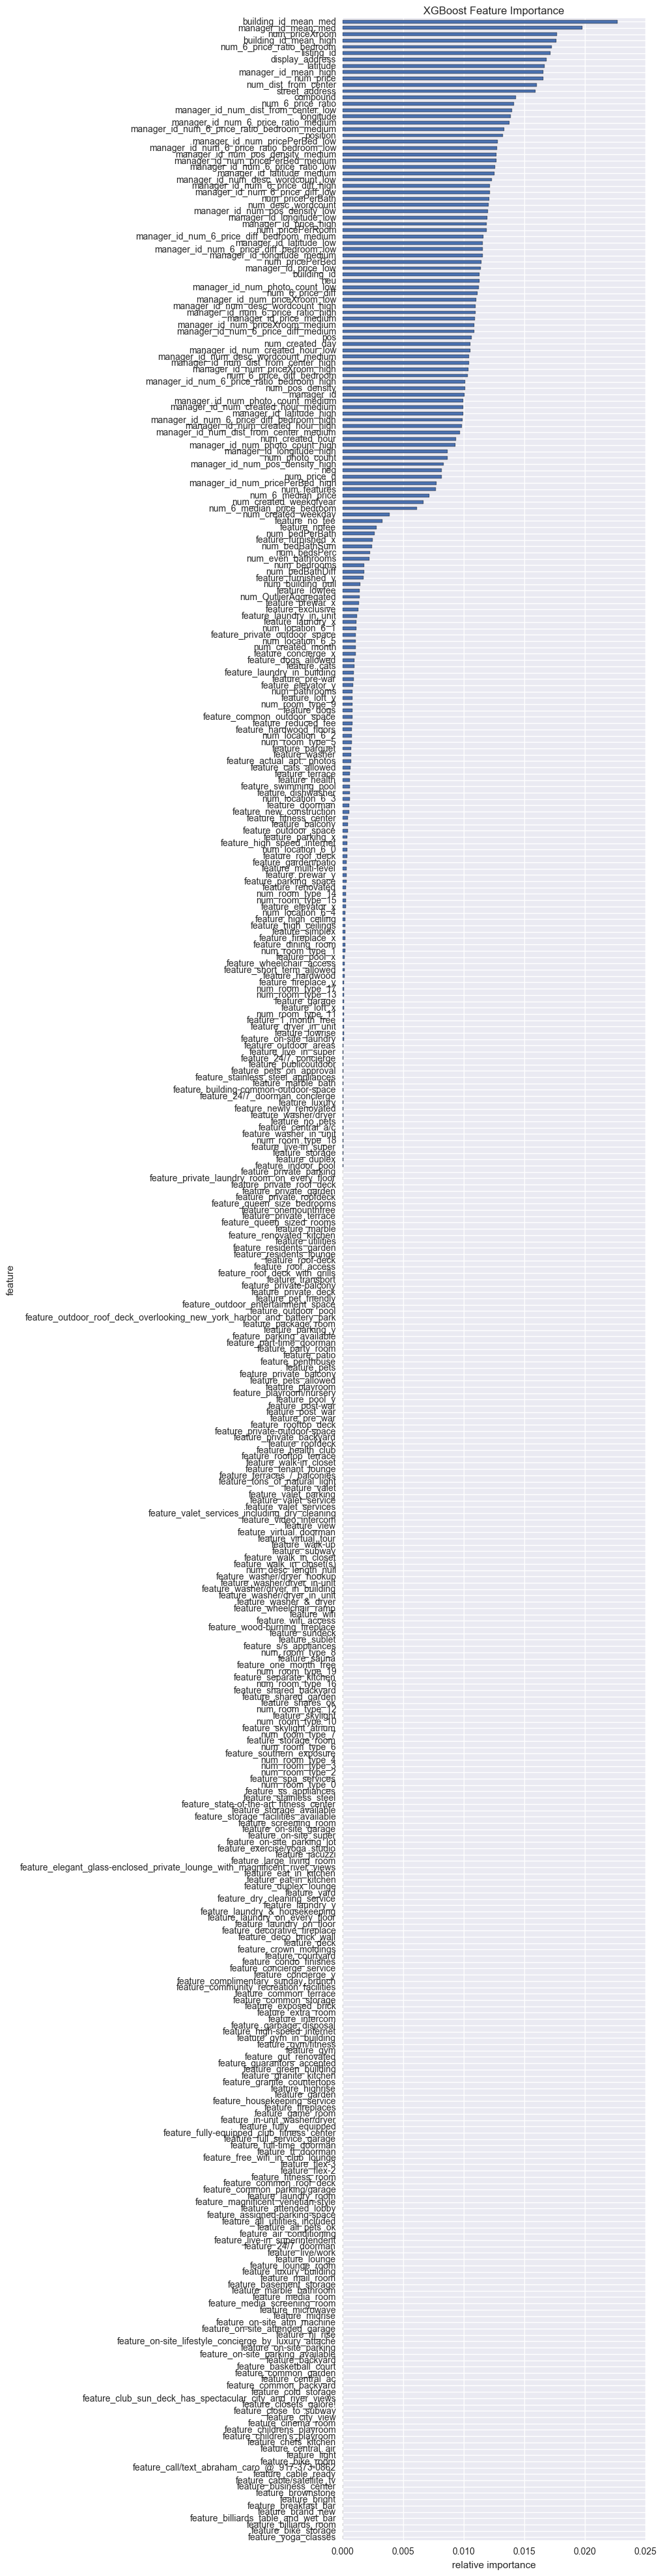

In [27]:
df = pd.DataFrame()
df['feature'] = X_train.columns.values
df['fscore'] = rgr.feature_importances_
df['fscore'] = df['fscore'] / df['fscore'].sum()
df = df.sort_values(by='fscore')


# plt.figure()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 50))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [32]:
train_X.to_csv(data_path + 'train_CV_statistics2.csv',index=False)
test_X.to_csv(data_path + 'test_CV_statistics2.csv',index=False)

In [4]:
data_path = "../input/"
train_X = pd.read_csv(data_path + 'train_CV_statistics.csv')
test_X = pd.read_csv(data_path + 'test_CV_statistics.csv')
train_y = np.ravel(pd.read_csv(data_path + 'train_y_CV_statistics.csv',header=None))
sub_id = test_X.listing_id.astype('int32').values

# all_features = features_to_use + desc_sparse_cols + feat_sparse_cols
print train_X.shape, test_X.shape, train_y.shape

(49352, 133) (74659, 133) (49352L,)


In [7]:
cv_feature = ['manager_id_num_6_price_ratio_bedroom_low',
       'manager_id_num_6_price_ratio_bedroom_medium',
       'manager_id_num_6_price_ratio_bedroom_high',
       'manager_id_num_priceXroom_low', 'manager_id_num_priceXroom_medium',
       'manager_id_num_priceXroom_high', 'manager_id_num_6_price_diff_low',
       'manager_id_num_6_price_diff_medium',
       'manager_id_num_6_price_diff_high',
       'manager_id_num_created_hour_low',
       'manager_id_num_created_hour_medium',
       'manager_id_num_created_hour_high', 'manager_id_price_low',
       'manager_id_price_medium', 'manager_id_price_high',
       'manager_id_num_6_price_diff_bedroom_low',
       'manager_id_num_6_price_diff_bedroom_medium',
       'manager_id_num_6_price_diff_bedroom_high',
       'manager_id_latitude_low', 'manager_id_latitude_medium',
       'manager_id_latitude_high', 'manager_id_num_dist_from_center_low',
       'manager_id_num_dist_from_center_medium',
       'manager_id_num_dist_from_center_high',
       'manager_id_num_pricePerBed_low',
       'manager_id_num_pricePerBed_medium',
       'manager_id_num_pricePerBed_high', 'manager_id_num_photo_count_low',
       'manager_id_num_photo_count_medium',
       'manager_id_num_photo_count_high',
       'manager_id_num_6_price_ratio_low',
       'manager_id_num_6_price_ratio_medium',
       'manager_id_num_6_price_ratio_high',
       'manager_id_num_desc_wordcount_low',
       'manager_id_num_desc_wordcount_medium',
       'manager_id_num_desc_wordcount_high',
       'manager_id_num_pos_density_low',
       'manager_id_num_pos_density_medium',
       'manager_id_num_pos_density_high', 'manager_id_longitude_low',
       'manager_id_longitude_medium', 'manager_id_longitude_high','listing_id']

In [21]:
data_path = "../input/"
train_X_0322 = pd.read_csv(data_path + 'train_BM_MB_add03052240.csv')
test_X_0322 = pd.read_csv(data_path + 'test_BM_MB_add03052240.csv')
train_y = np.ravel(pd.read_csv(data_path + 'labels_BrandenMurray.csv'))
print train_X_0322.shape
print test_X_0322.shape

(49352, 322)
(74659, 322)


In [22]:
train_X_0322 = train_X_0322.drop(labels='feature_on-site_lifestyle_concierge_by_luxury_attach\xc3\xa9',axis=1)
test_X_0322 = test_X_0322.drop(labels='feature_on-site_lifestyle_concierge_by_luxury_attach\xc3\xa9',axis=1)

In [25]:
test_X_0322.isnull().values.any()

False

In [26]:
train_X_0322 = train_X_0322.merge(train_X[cv_feature],on='listing_id', how='left')
test_X_0322 = test_X_0322.merge(test_X[cv_feature],on='listing_id', how='left')

In [29]:
print cv_train(train_X_0322,train_y)

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[90]	train-mlogloss:0.312701+0.00418936	test-mlogloss:0.535279+0.00370449

0.5352786


In [34]:
X_train, X_val, y_train, y_val = train_test_split(train_X_0322, train_y, train_size=.80, random_state=4)
rgr = xgb.XGBClassifier(
            objective='multi:softprob',
            seed = 0, # use a fixed seed during tuning so we can reproduce the results
            learning_rate = 0.2,
            n_estimators = 100000,
            max_depth= 6,
            nthread = -1,
            colsample_bytree = 0.3,
            subsample =0.7,
            silent = 1
        )
rgr.fit(
        X_train,y_train,
        eval_set=[(X_val,y_val)],
        eval_metric='mlogloss',
        early_stopping_rounds=20,
        verbose=20
    )

[0]	validation_0-mlogloss:0.978232
Will train until validation_0-mlogloss hasn't improved in 20 rounds.
[20]	validation_0-mlogloss:0.576067
[40]	validation_0-mlogloss:0.550797
[60]	validation_0-mlogloss:0.540388
[80]	validation_0-mlogloss:0.535674
[100]	validation_0-mlogloss:0.533424
[120]	validation_0-mlogloss:0.532149
[140]	validation_0-mlogloss:0.531932
Stopping. Best iteration:
[133]	validation_0-mlogloss:0.531664



XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.3,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=0.7)

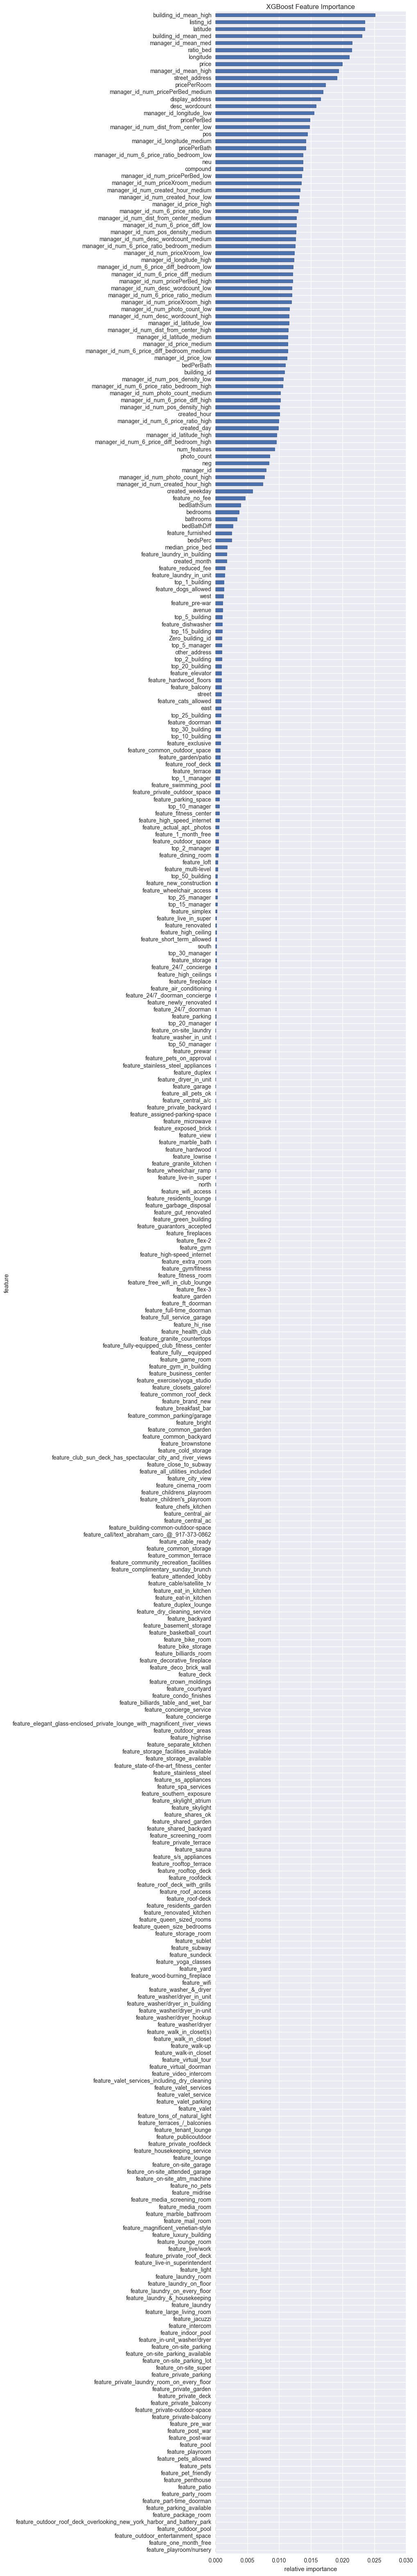

In [35]:
df = pd.DataFrame()
df['feature'] = X_train.columns.values
df['fscore'] = rgr.feature_importances_
df['fscore'] = df['fscore'] / df['fscore'].sum()
df = df.sort_values(by='fscore')


# plt.figure()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 80))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')